In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datacompy
import os, sys
import numpy as np

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy import stats

# modele
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# methods
from imblearn.under_sampling import ClusterCentroids, NearMiss
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

### Oversampling NEW

In [41]:
#read data
df = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\SSH.csv")
print(df.columns)
df = df.drop_duplicates()
print(df)

#label encoding
labelencoder = LabelEncoder()
#label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
column = "user"
df_encoded = labelencoder.fit_transform(df[column])
df_encoded = pd.DataFrame(df_encoded, columns=[column])
df_encoded = pd.concat([df_encoded, df.drop(columns=column)], axis=1)
df_encoded = df_encoded.drop(index=76)
df_encoded.loc[282, "user"] = 30


columns_to_convert = [col for col in df_encoded.columns if col != "ts"]
df_encoded[columns_to_convert] = df_encoded[columns_to_convert].astype(int)
print(df_encoded)
print(df_encoded.dtypes)
#standardize data
scaler = StandardScaler()
df_encoded["ts"] = scaler.fit_transform(df_encoded[["ts"]])

#split data
y = df_encoded["target"]
X = df_encoded.drop(columns=["target"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

#df_train summary X_train, y_train
df_train = pd.concat([X_train, y_train], axis=1) 
df_train['source'] = 'original' 
df_train.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\original_data.csv")

y_test.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\y_test.csv")
X_test.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\X_test.csv")

Index(['user', 'is_private', 'is_failure', 'is_root', 'is_valid',
       'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'first',
       'td', 'ts', 'target'],
      dtype='object')
        user  is_private  is_failure  is_root  is_valid  not_valid_count  \
0     kamran           1           1        0         1                0   
1     kamran           1           1        0         1                0   
2    student           1           0        0         1                0   
3     kamran           1           1        0         1                0   
4     kamran           1           1        0         1                0   
..       ...         ...         ...      ...       ...              ...   
278   osamac           1           1        0         1                0   
279   osamac           1           1        0         1                0   
280   osamac           1           0        0         1                0   
281   osamac           1           0        0

Przed Counter({0: 151, 1: 46})
Po Counter({0: 151, 1: 151})


<Axes: xlabel='target'>

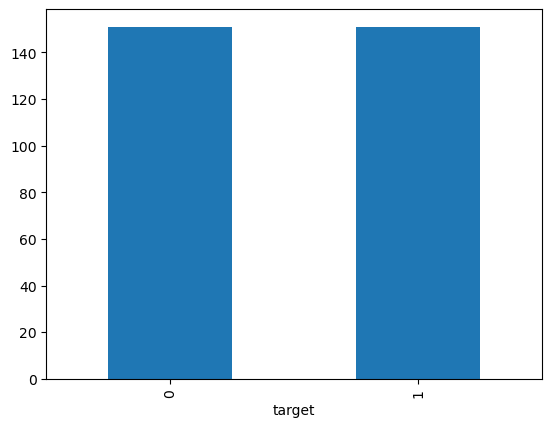

In [72]:
file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\smote_data.csv"
#zamiana jesli istnieje to wczytaj plik jesli nie to stworz
con = Counter(y_train)
print("Przed", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

train_data_smote = pd.concat([X_train_sm, y_train_sm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_smote['generated_by_smote'] = ['original' if i < len(df_train) else 'smote' for i in range(len(train_data_smote))]
smote_data = train_data_smote[train_data_smote['generated_by_smote'] == 'smote'].drop('generated_by_smote', axis=1)
smote_data["source"] = "smote"
if not os.path.exists(file_path1):
    smote_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}')
con1 = Counter(y_train_sm)
print("Po", con1)
pd.Series(y_train_sm).value_counts().plot.bar()

Przed Counter({0: 151, 1: 46})
Po Counter({0: 151, 1: 151})
(302, 12) (302,)


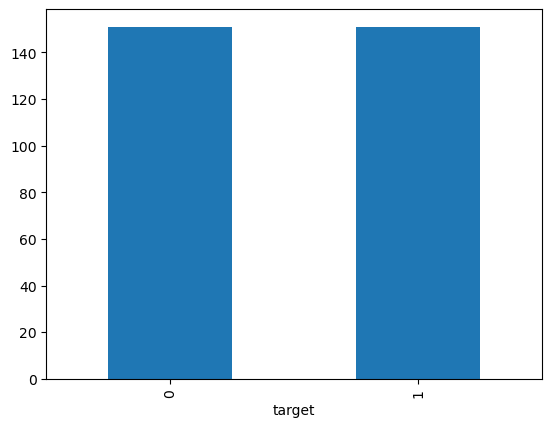

In [43]:
file_path2 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\borderline_data.csv"
#generate new data by borderLineSMOTE
con3 = Counter(y_train)
print("Przed", con3)
brdsmote = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = brdsmote.fit_resample(X_train, y_train)
con4 = Counter(y_train_bsm)
print("Po", con4)

train_data_borderline_smote = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_borderline_smote['generated_by_borderline_smote'] = ['original' if i < len(df_train) else 'brd smote' for i in range(len(train_data_borderline_smote))]
boarderline_smote_data = train_data_borderline_smote[train_data_borderline_smote['generated_by_borderline_smote'] == 'brd smote'].drop('generated_by_borderline_smote', axis=1)
boarderline_smote_data["source"]="borderline smote"
boarderline_smote_data = boarderline_smote_data[boarderline_smote_data['source'] != 'original']
if not os.path.exists(file_path2):
    boarderline_smote_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')

pd.Series(y_train_bsm).value_counts().plot.bar()
print(X_train_bsm.shape, y_train_bsm.shape)

In [ ]:
label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

Dane wygenerowane:  target
1    105
Name: count, dtype: int64
Before Counter({0: 151, 1: 46})
After Counter({0: 151, 1: 151})
0      37
1      12
2      15
3       2
4      42
       ..
100    21
101    44
102    44
103    18
104     1
Name: user, Length: 105, dtype: int32


<Axes: xlabel='target'>

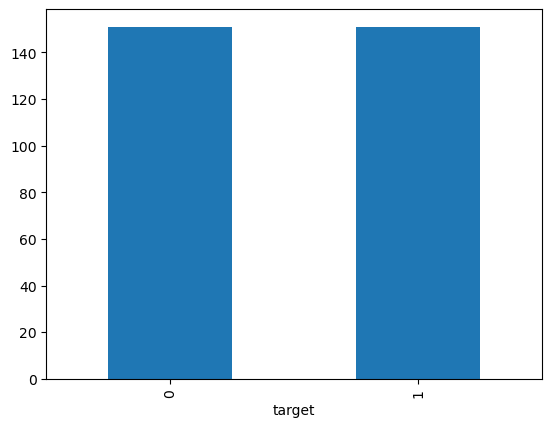

In [ ]:
file_path3 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
#generate new data by GAN

#data preparation
indexes_to_remove = y_test.index
df_gan = df.drop(index=indexes_to_remove)



columns_list = df_gan.columns
target_num = df_gan['target'].value_counts()
ctgan = CTGAN(epochs=10)        #model

if target_num[0] > target_num[1]:
    data_y1 = df_gan[df_gan['target']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['target'].value_counts())
    balanced_data = pd.concat([df_gan, df_GAN], ignore_index=False)
else:
    data_y0 = df_gan[df_gan['target']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['target'].value_counts())
    balanced_data = pd.concat([df_gan, df_GAN], ignore_index=False)



#balanced_data = balanced_data.drop(columns=["source"])  
y_train_gan = balanced_data["target"]
X_train_gan = balanced_data.drop(columns=["target"])
con5 = Counter(y_train)
print("Before", con5)
con6 = Counter(y_train_gan)
print("After", con6)
gan_data = df_GAN

#label encoding + standardize
gan_data["user"] = gan_data["user"].map(label_mapping).fillna(-1).astype(int)
column = "user"
gan_data["ts"] = scaler.fit_transform(gan_data[["ts"]])

gan_data["source"] = "gan"
if not os.path.exists(file_path3):
    gan_data.to_csv(file_path3, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path3}')

pd.Series(y_train_gan).value_counts().plot.bar()

### Data

In [73]:
#oversampling data
original_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\original_data.csv")
original_data = original_data.drop(columns=["Unnamed: 0"])
smote_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\smote_data.csv")
GAN_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\GAN_data.csv")
borderline_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\borderline_data.csv")

# test data
X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\y_test.csv")

In [74]:
data1 = pd.concat([GAN_data, smote_data], axis=0, ignore_index=True)
data2 = pd.concat([borderline_data, original_data], axis=0, ignore_index=True)
NM_data = pd.concat([data1, data2], axis=0, ignore_index=True)
#NM_data = NM_data.drop(index=397)
#NM_data = NM_data.reset_index(drop=True) 


y_under_NM = NM_data['target']
X_under_NM = NM_data.drop(columns=["target", "source"]) 
NM = NearMiss()
X_NM, y_NM = NM.fit_resample(X_under_NM, y_under_NM)

In [77]:
# sprawdzanie czy sa wartosci NaN
data_check = NM_data
nan_rows = data_check[data_check.isna().any(axis=1)]
print(f"Liczba wierszy z NaN: {nan_rows.shape[0]}")
print("Wiersze z NaN:")
print(nan_rows)

Liczba wierszy z NaN: 0
Wiersze z NaN:
Empty DataFrame
Columns: [user, is_private, is_failure, is_root, is_valid, not_valid_count, ip_failure, ip_success, no_failure, first, td, ts, target, source]
Index: []
